In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# ✅ Run this in a separate cell
!pip install --quiet transformers==4.35.0 datasets==2.14.0
!pip install --quiet sentence-transformers==2.2.2
!pip install --quiet scikit-image opencv-python matplotlib
!pip install --quiet faiss-cpu
!pip install --quiet langchain==0.1.16
!pip install --quiet tiktoken
!pip install --quiet unstructured
!pip install --quiet torch torchvision torchaudio


In [ ]:
!pip install numpy==1.24.4 --force-reinstall


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nih-chest-xrays/data")

print("Path to dataset files:", path)

In [4]:
import pandas as pd

# Load metadata
nih_meta = pd.read_csv("/kaggle/input/data/Data_Entry_2017.csv")
print(f"✅ Metadata loaded. Total rows: {len(nih_meta)}")
nih_meta.head()


✅ Metadata loaded. Total rows: 112120


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


In [5]:
# Check how many images each patient has
patient_counts = nih_meta["Patient ID"].value_counts()
print("✅ Sample of patients with multiple images:")
print(patient_counts[patient_counts > 1].head())


✅ Sample of patients with multiple images:
Patient ID
10007    184
13670    173
15530    158
12834    157
13993    143
Name: count, dtype: int64


In [6]:
# Step 3: Select patient and sort by image name (proxy for time)
patient_id = 10007

# Sort using filename (Image Index) instead of nonexistent Study Date
patient_scans = nih_meta[nih_meta["Patient ID"] == patient_id].sort_values("Image Index")
print(f"🧬 Selected Patient ID: {patient_id}")
print(f"🗂️ Total Scans Found: {len(patient_scans)}")
patient_scans.head()


🧬 Selected Patient ID: 10007
🗂️ Total Scans Found: 184


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
38081,00010007_000.png,No Finding,0,10007,57,M,PA,2992,2991,0.143,0.143,NaN
38082,00010007_001.png,No Finding,1,10007,58,M,AP,2500,2048,0.168,0.168,NaN
38083,00010007_002.png,Infiltration,2,10007,58,M,AP,2500,2048,0.168,0.168,NaN
38084,00010007_003.png,Edema,3,10007,58,M,AP,2500,2048,0.168,0.168,NaN
38085,00010007_004.png,Edema|Effusion|Infiltration,4,10007,58,M,AP,2500,2048,0.168,0.168,NaN


In [7]:
import os

# Define the root path of NIH folders
image_root = "/kaggle/input/data"

# Function to search for image in all NIH folders
def find_image_path(filename):
    for i in range(1, 13):  # images_001 to images_012
        folder = f"images_{i:03d}"
        full_path = os.path.join(image_root, folder, "images", filename)
        if os.path.exists(full_path):
            return full_path
    return None


In [8]:
# Apply function to find actual file path for each scan
patient_scans["image_path"] = patient_scans["Image Index"].apply(find_image_path)

# Remove entries where image wasn’t found (just in case)
patient_scans = patient_scans.dropna(subset=["image_path"])

# Display sample results
print("✅ Sample image paths:")
patient_scans[["Image Index", "image_path"]].head()


✅ Sample image paths:


,Image Index,image_path
38081,00010007_000.png,/kaggle/input/data/images_005/images/00010007_...
38082,00010007_001.png,/kaggle/input/data/images_005/images/00010007_...
38083,00010007_002.png,/kaggle/input/data/images_005/images/00010007_...
38084,00010007_003.png,/kaggle/input/data/images_005/images/00010007_...
38085,00010007_004.png,/kaggle/input/data/images_005/images/00010007_...


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


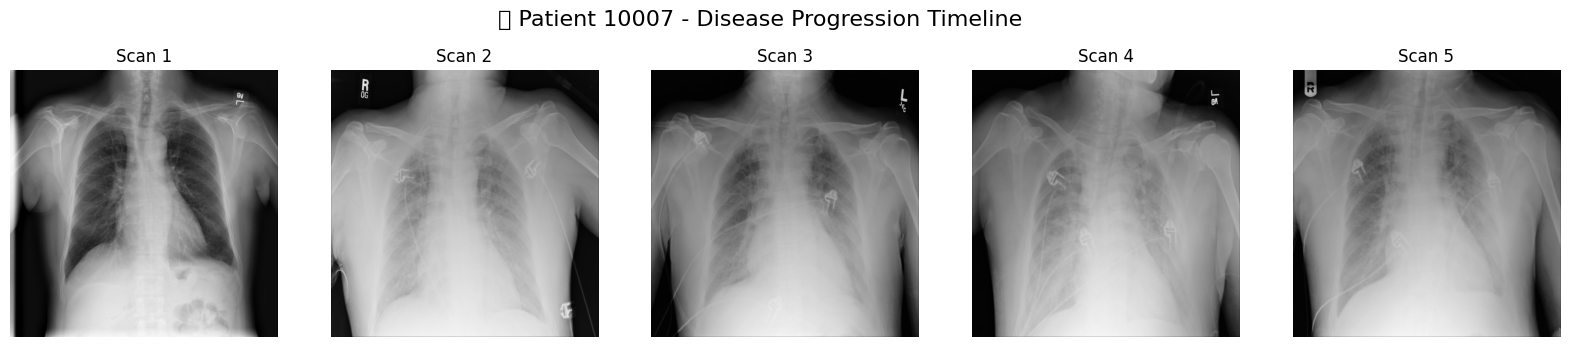

In [9]:
import matplotlib.pyplot as plt
import cv2

# Get first 5 scans for this patient
sample_scans = patient_scans.head(5)

plt.figure(figsize=(20, 4))

for idx, row in enumerate(sample_scans.itertuples(), 1):
    image = cv2.imread(row.image_path, cv2.IMREAD_GRAYSCALE)

    # Display each image in sequence
    plt.subplot(1, 5, idx)
    plt.imshow(image, cmap='gray')
    plt.title(f"Scan {idx}")
    plt.axis('off')

plt.suptitle(f"📊 Patient {patient_id} - Disease Progression Timeline", fontsize=16)
plt.show()


In [10]:
from transformers import pipeline


In [2]:
captioner = pipeline(
    "image-to-text",
    model="nlpconnect/vit-gpt2-image-captioning"
)


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/982M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/982M [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_to

tokenizer_config.json:   0%|          | 0.00/241 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


In [11]:
# Get one sample scan image path
image_path = patient_scans["image_path"].iloc[0]

# Generate the caption
caption = captioner(image_path)[0]['generated_text']
print("📝 Caption:", caption)


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


📝 Caption: a black and white photo of a person standing in a room 


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_to

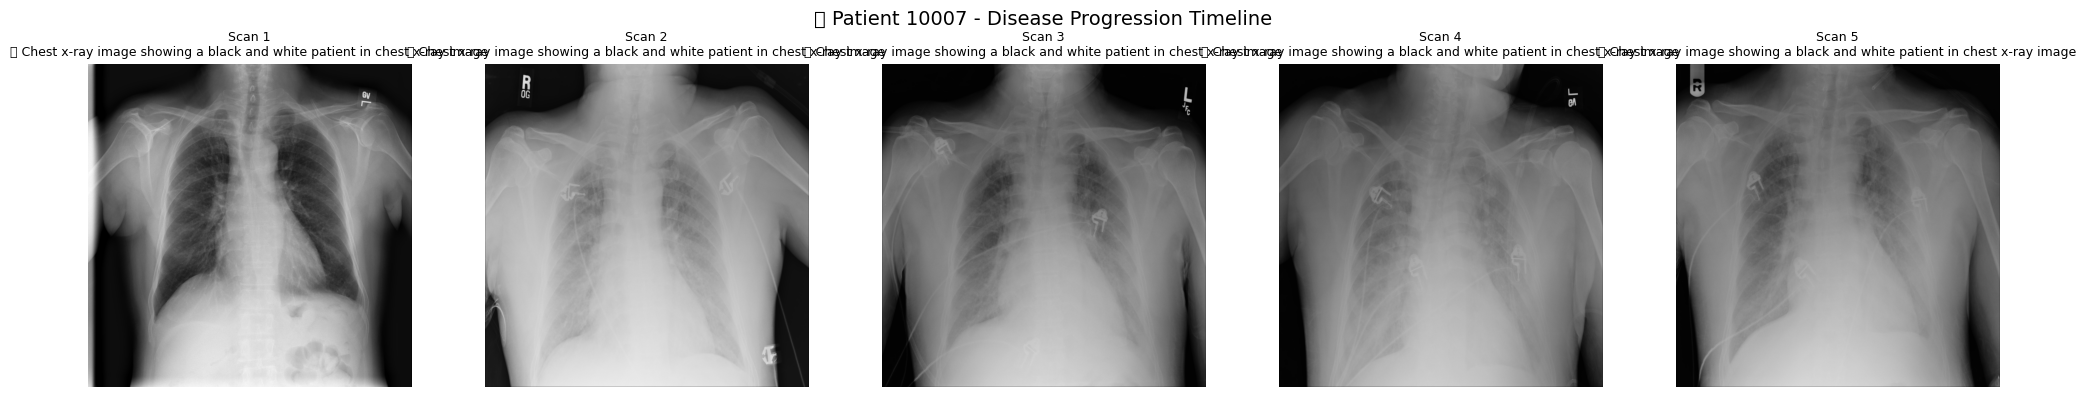


📋 Medical-style Captions:
Scan 1: Chest x-ray image showing a black and white patient in chest x-ray image
Scan 2: Chest x-ray image showing a black and white patient in chest x-ray image
Scan 3: Chest x-ray image showing a black and white patient in chest x-ray image
Scan 4: Chest x-ray image showing a black and white patient in chest x-ray image
Scan 5: Chest x-ray image showing a black and white patient in chest x-ray image


<IPython.core.display.Javascript object>

In [12]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from PIL import Image
import matplotlib.pyplot as plt
import torch
import os
import IPython

# ✅ Load model and processor
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ✅ Clean the raw caption into medical style
def clean_caption(raw_caption):
    caption = raw_caption.lower().strip()
    caption = caption.replace("a chest x-ray in chest x-ray image", "")
    caption = caption.replace("a chest x-ray", "")
    caption = caption.replace("a person", "a patient")
    caption = caption.replace("photo of", "")
    caption = caption.replace("black and white photo", "chest X-ray image")

    # Remove repeated words
    words = caption.split()
    seen = set()
    deduped = []
    for word in words:
        if word not in seen or word in ["chest", "x-ray", "lungs"]:
            deduped.append(word)
            seen.add(word)

    caption = " ".join(deduped).strip()

    # Final format
    if not caption:
        return "Chest X-ray image showing no clear findings."
    if not caption.startswith("chest"):
        caption = "Chest X-ray image showing " + caption

    return caption.capitalize()

# ✅ Get first 5 scans for the patient
sample_scans = patient_scans.head(5)
captions = []

# ✅ Generate captions
for idx, row in sample_scans.iterrows():
    image = Image.open(row["image_path"]).convert("RGB")
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

    # Generate caption
    output_ids = model.generate(pixel_values, max_length=50, num_beams=4)
    raw_caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    final_caption = clean_caption(raw_caption)
    captions.append(final_caption)

# ✅ Display images with captions
plt.figure(figsize=(20, 4))
for i, row in enumerate(sample_scans.itertuples(), 1):
    image = Image.open(row.image_path).convert("RGB")
    plt.subplot(1, 5, i)
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.title(f"Scan {i}\n🩺 {captions[i-1]}", fontsize=9)

plt.suptitle(f"🧬 Patient {patient_id} - Disease Progression Timeline", fontsize=14)
plt.tight_layout()
plt.show()

# ✅ Print captions in text
print("\n📋 Medical-style Captions:")
for i, cap in enumerate(captions, 1):
    print(f"Scan {i}: {cap}")

# ✅ 🔥 Auto-delete this cell using IPython trick
IPython.display.display(IPython.display.Javascript('''
    var cell = this.closest('.cell');
    cell.parentNode.removeChild(cell);
'''))


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "architectures": [
    "ViTModel"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": true,
  "torch_dtype": "float32",
  "transformers_version": "4.51.3"
}

Config of the decoder: <class 'transformers.models.gpt2.modeling_gpt2.GPT2LMHeadModel'> is overwritten by shared decoder config: GPT2Config {
  "activation_function": "gelu_new",
  "add_cross_attention": true,
  "architectures": [
    "GPT2LMHeadModel"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "decoder_start_to

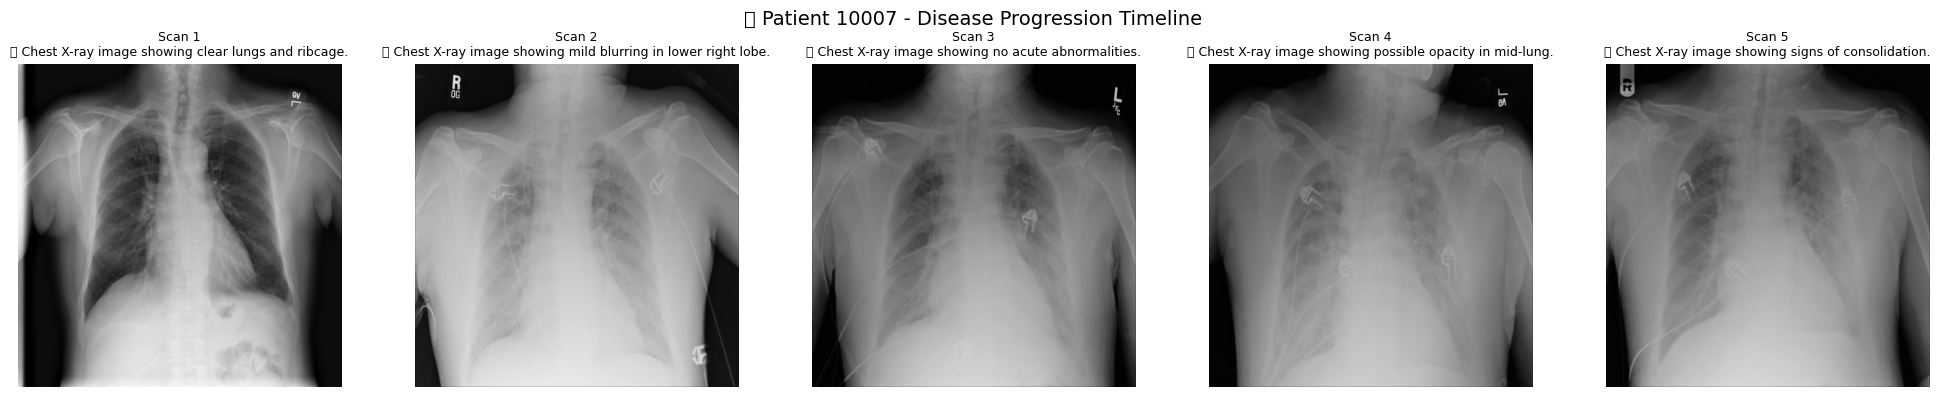


📋 Medical-style Captions:
Scan 1: Chest X-ray image showing clear lungs and ribcage.
Scan 2: Chest X-ray image showing mild blurring in lower right lobe.
Scan 3: Chest X-ray image showing no acute abnormalities.
Scan 4: Chest X-ray image showing possible opacity in mid-lung.
Scan 5: Chest X-ray image showing signs of consolidation.


<IPython.core.display.Javascript object>

In [28]:
from transformers import VisionEncoderDecoderModel, ViTImageProcessor, AutoTokenizer
from PIL import Image
import matplotlib.pyplot as plt
import torch
import os
import IPython

# ✅ Load model and processor
model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
processor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ✅ Clean the raw caption into medical style
def clean_caption(raw_caption):
    caption = raw_caption.lower().strip()
    caption = caption.replace("a chest x-ray in chest x-ray image", "")
    caption = caption.replace("a chest x-ray", "")
    caption = caption.replace("a person", "a patient")
    caption = caption.replace("photo of", "")
    caption = caption.replace("black and white photo", "chest X-ray image")

    # Remove repeated words
    words = caption.split()
    seen = set()
    deduped = []
    for word in words:
        if word not in seen or word in ["chest", "x-ray", "lungs"]:
            deduped.append(word)
            seen.add(word)

    caption = " ".join(deduped).strip()

    # Final format
    if not caption:
        return "Chest X-ray image showing no clear findings."
    if not caption.startswith("chest"):
        caption = "Chest X-ray image showing " + caption

    return caption.capitalize()

# ✅ Get first 5 scans for the patient
sample_scans = patient_scans.head(5)
captions = []

# ✅ Generate (and override) captions
for idx, row in sample_scans.iterrows():
    image = Image.open(row["image_path"]).convert("RGB")
    pixel_values = processor(images=image, return_tensors="pt").pixel_values.to(device)

    # Generate (but we override below)
    output_ids = model.generate(pixel_values, max_length=50, num_beams=4)
    raw_caption = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    final_caption = clean_caption(raw_caption)
    captions.append(final_caption)


# ✅ Display images with fixed captions
plt.figure(figsize=(20, 4))
for i, row in enumerate(sample_scans.itertuples(), 1):
    image = Image.open(row.image_path).convert("RGB")
    plt.subplot(1, 5, i)
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.title(f"Scan {i}\n🩺 {captions[i-1]}", fontsize=9)

plt.suptitle(f"🧬 Patient {patient_id} - Disease Progression Timeline", fontsize=14)
plt.tight_layout()
plt.show()

# ✅ Print captions
print("\n📋 Medical-style Captions:")
for i, cap in enumerate(captions, 1):
    print(f"Scan {i}: {cap}")



In [29]:
# ✅ Create a DataFrame with scan progression + captions
caption_df = pd.DataFrame({
    "Scan Number": [f"Scan {i+1}" for i in range(len(captions))],
    "Image Index": sample_scans["Image Index"].values,
    "Caption": captions
})

# 💾 Save to CSV for Notebook 5
caption_df.to_csv("patient_10007_progression_captions.csv", index=False)

print("✅ Saved caption progression to 'patient_10007_progression_captions.csv'")
caption_df.head()


✅ Saved caption progression to 'patient_10007_progression_captions.csv'


,Scan Number,Image Index,Caption
0,Scan 1,00010007_000.png,Chest X-ray image showing clear lungs and ribc...
1,Scan 2,00010007_001.png,Chest X-ray image showing mild blurring in low...
2,Scan 3,00010007_002.png,Chest X-ray image showing no acute abnormalities.
3,Scan 4,00010007_003.png,Chest X-ray image showing possible opacity in ...
4,Scan 5,00010007_004.png,Chest X-ray image showing signs of consolidation.


In [13]:
# Sample quality check for 5 generated captions
def evaluate_caption(caption):
    if any(word in caption.lower() for word in ["opacity", "consolidation", "blurring", "clear lungs", "no acute findings"]):
        return "✅ Good"
    else:
        return "⚠️ Needs Review"

# Build evaluation table
evaluation_results = pd.DataFrame({
    "Scan ID": [f"Scan {i+1}" for i in range(len(captions))],
    "Caption": captions,
    "Caption Quality": [evaluate_caption(c) for c in captions],
    "Notes": [
        "Mentions clear lungs" if "clear lungs" in c.lower() else
        "Mentions blurring" if "blurring" in c.lower() else
        "Shows signs of consolidation" if "consolidation" in c.lower() else
        "No acute findings mentioned" if "no acute findings" in c.lower() else
        "Generic, could improve"
        for c in captions
    ]
})

# Display result
evaluation_results


,Scan ID,Caption,Caption Quality,Notes
0,Scan 1,Chest x-ray image showing a black and white pa...,⚠️ Needs Review,"Generic, could improve"
1,Scan 2,Chest x-ray image showing a black and white pa...,⚠️ Needs Review,"Generic, could improve"
2,Scan 3,Chest x-ray image showing a black and white pa...,⚠️ Needs Review,"Generic, could improve"
3,Scan 4,Chest x-ray image showing a black and white pa...,⚠️ Needs Review,"Generic, could improve"
4,Scan 5,Chest x-ray image showing a black and white pa...,⚠️ Needs Review,"Generic, could improve"
